Authorship Threshold Analysis
===

Analysis of the degree to which there is variance in users.

The set of valid users is FIXED, based on authorship criteria.

The set of sites for which each user is considered an author is VARIABLE based on authorship determination.

We want to model two things:
 - Initiation with others *sites*
 - Initiation with other *users*
 
We want to label users with site characteristics based on their authorship of that site.

This notebook was almost entirely replaced by the `Demonstration` notebook, which really should be updated and transitioned 


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [97]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm, tqdm_notebook
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [4]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [5]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data"
assert os.path.exists(working_dir)

In [6]:
# load the list of valid users
data_selection_working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362370

In [7]:
gb_filtered_filepath = os.path.join(working_dir, "old_gb_metadata_filtered.csv")
comments_filtered_filepath = os.path.join(working_dir, "new_comments_metadata_filtered.csv")
amps_filtered_filepath = os.path.join(working_dir, "new_amps_metadata_filtered.csv")

gb_cols = ['user_id', 'site_id', 'int_type', 'created_at', 'updated_at']
comments_cols = ['user_id','site_id','int_type','journal_oid','created_at','updated_at']
amps_cols = ['user_id','site_id','journal_oid','journal_user_id','created_at','updated_at']

s = datetime.now()
gb_df = pd.read_csv(gb_filtered_filepath, header=None, names=gb_cols)
print(datetime.now() - s)
print("guestbook", len(gb_df))

s = datetime.now()
comments_df = pd.read_csv(comments_filtered_filepath, header=None, names=comments_cols)
print(datetime.now() - s)
print("comments", len(comments_df))

s = datetime.now()
amps_df = pd.read_csv(amps_filtered_filepath, header=None, names=amps_cols, low_memory=False)
print(datetime.now() - s)
print("amps", len(amps_df))

0:00:05.091977
guestbook 5864304
0:00:01.900648
comments 1094435
0:00:06.228976
amps 3536819


In [8]:
gb_counts = defaultdict(int)
for user_id in gb_df.user_id:
    gb_counts[user_id] += 1

comments_counts = defaultdict(int)
for user_id in comments_df.user_id:
    comments_counts[user_id] += 1

amps_counts = defaultdict(int)
for user_id in amps_df.user_id:
    amps_counts[user_id] += 1

users = []
for user_id in tqdm(set(gb_df.user_id) | set(comments_df.user_id) | set(amps_df.user_id)):
    u = {
        'user_id': user_id,
        'total_guestbook_count': gb_counts[user_id],
        'total_comments_count': comments_counts[user_id],
        'total_amps_count': amps_counts[user_id]
    }
    users.append(u)
user_ints_df = pd.DataFrame(users)
len(user_ints_df)

100%|██████████| 275291/275291 [00:00<00:00, 350040.51it/s]


275291

In [9]:
user_ints_df.head()

,total_amps_count,total_comments_count,total_guestbook_count,user_id
0,22,5,3,3145728
1,0,0,1,1
2,0,0,47,2
3,0,2,3,1048579
4,0,0,1,6


In [10]:
amps_df['int_type'] = 'amps'
cols = ['user_id', 'site_id', 'int_type']
ints_df = pd.concat([gb_df[cols], comments_df[cols], amps_df[cols]], axis=0)
ints_df.sort_values(by='user_id', inplace=True)
ints_df.reset_index(drop=True, inplace=True)
len(ints_df)

10495558

In [11]:
ints_df.head()

,user_id,site_id,int_type
0,1,6214,guestbook
1,2,2,guestbook
2,2,13741,guestbook
3,2,13738,guestbook
4,2,2,guestbook


In [12]:
Counter(ints_df.int_type).most_common()

[('guestbook', 5864304), ('amps', 3536819), ('comment', 1094435)]

#### Load the author-site associations and counts

Contains info about all the updates authored for each user in the valid sample

In [13]:
# read feathered user author info dataframe
user_metadata_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/user_metadata"
user_info_filepath = os.path.join(user_metadata_dir, 'user_metadata.feather')
user_info_df = pd.read_feather(user_info_filepath)

# convert list datatypes from strings into actual lists
for col in user_info_df.columns:
    if "_list" in col:
        user_info_df[col] = [eval(list_string) for list_string in user_info_df[col]]

len(user_info_df)

667573

In [14]:
user_info_df.head()

,is_site_valid_list,is_user_valid,site_first_created_update_list,site_first_index_update_list,site_id_list,site_last_created_update_list,site_last_index_update_list,site_total_update_count_list,site_update_count_list,total_sites,total_updates,user_id
0,[True],True,[1103856900000],[0],[1],[1261008420000],[186],[187],[187],1,187,1
1,[True],True,[1117053060000],[0],[2],[1180149600000],[28],[29],[29],1,29,2
2,[False],False,[1147748940000],[1],[4],[1147748940000],[1],[1],[1],1,1,4
3,[True],True,[1112730300000],[0],[6],[1372436275000],[16],[17],[17],1,17,6
4,[True],True,[1116042900000],[0],[10],[1117635660000],[14],[15],[15],1,15,12


In [15]:
author_df = user_info_df[user_info_df.is_user_valid]
len(author_df), len(author_df) / len(user_info_df)

(362370, 0.5428170402338022)

In [16]:
all_site_ids_with_valid_author = set()
for site_id_list in tqdm(author_df.site_id_list):
    for site_id in site_id_list:
        all_site_ids_with_valid_author.add(site_id)
len(all_site_ids_with_valid_author)

100%|██████████| 362370/362370 [00:00<00:00, 1263179.10it/s]


340804

#### Associate sites as valid-authored or not

In [17]:
int_site_ids = set(ints_df.site_id)
len(int_site_ids), len(int_site_ids & all_site_ids_with_valid_author) / len(all_site_ids_with_valid_author)

(283111, 0.7306839121606554)

The above set intersection demonstrates that 73% of sites that contain at least one update authored by a valid user also have interactions from at least one valid author.  This includes self-interactions!

What we want to compute is the percentage of interactions

In [18]:
author_user_id_to_site_id_map = {user_id: set(site_id_list) 
                                 for user_id, site_id_list 
                                 in tqdm(zip(author_df.user_id, author_df.site_id_list))}

362370it [00:01, 313510.40it/s]


In [19]:
ints_df['is_author_interaction'] = [site_id in author_user_id_to_site_id_map[user_id]
                                 for user_id, site_id 
                                 in tqdm(zip(ints_df.user_id, ints_df.site_id), total=len(ints_df))]

100%|██████████| 10495558/10495558 [00:06<00:00, 1542432.74it/s]


In [20]:
# 13% of interactions are "self-interactions", defined with the broadest possible definition of authorship
len(ints_df[ints_df.is_author_interaction]) / len(ints_df)

0.129803960875639

In [21]:
threshold = 1.0  # what percent of journals need to be patient authored
thresholded_author_user_id_to_site_id_map = {user_id: set([site_id 
                                               for site_id, site_update_count, site_total_update_count 
                                               in zip(site_id_list, site_update_count_list, site_total_update_count_list)
                                               if site_update_count / site_total_update_count >= threshold]) 
                                 for user_id, site_id_list, site_update_count_list, site_total_update_count_list 
                                 in tqdm(zip(author_df.user_id, author_df.site_id_list, author_df.site_update_count_list, author_df.site_total_update_count_list), total=len(author_df))}

100%|██████████| 362370/362370 [00:00<00:00, 368069.49it/s]


In [22]:
np.sum([site_id in thresholded_author_user_id_to_site_id_map[user_id]
                                 for user_id, site_id 
                                 in tqdm(zip(ints_df.user_id, ints_df.site_id), total=len(ints_df))]) / len(ints_df)

100%|██████████| 10495558/10495558 [00:06<00:00, 1547693.91it/s]


0.054781651437684396

In [23]:
ints_author_id_set = set(ints_df.user_id)
len(ints_author_id_set)

275291

In [24]:
multi_site_author_id_set = set(author_df[author_df.total_sites > 1].user_id)
len(multi_site_author_id_set), len(multi_site_author_id_set) / len(author_df)

(18716, 0.05164886717995419)

In [25]:
# 13% of interactions are from authors who posted on 2+ sites
# Since these authors are only 5% of total authors, we can conclude that these authors interact more on average
total_ints_from_multiauthors = len(ints_df[ints_df.user_id.isin(multi_site_author_id_set)])
total_ints_from_multiauthors / len(ints_df)

0.13721614420119443

In [26]:
is_any_site_partialauthored = \
        [np.any([site_update_count != site_total_update_count
            for site_update_count, site_total_update_count 
            in zip(site_update_count_list, site_total_update_count_list)])
        for user_id, site_update_count_list, site_total_update_count_list 
        in zip(author_df.user_id, author_df.site_update_count_list, author_df.site_total_update_count_list)]
partialsite_author_id_set = set(author_df[is_any_site_partialauthored].user_id)
len(partialsite_author_id_set), len(partialsite_author_id_set) / len(author_df)

(96747, 0.2669840218561139)

In [27]:
# 37% of interactions are from authors who partially-authored at least one site
# Since these authors are only 27% of total authors, we can conclude that these authors interact more on average
total_ints_from_partialauthors = len(ints_df[ints_df.user_id.isin(partialsite_author_id_set)])
total_ints_from_partialauthors / len(ints_df)

0.36738761293110855

In [28]:
# to make the following function faster, we precompute some of the set indices we need for the ints_df
ints_df_multisite_author_inds = ints_df.user_id.isin(multi_site_author_id_set)
assert len(ints_df_multisite_author_inds) == len(ints_df)
ints_df_partialsite_author_inds = ints_df.user_id.isin(partialsite_author_id_set)
assert len(ints_df_partialsite_author_inds) == len(ints_df)

In [40]:
def compute_author_selfinteraction_proportion(threshold):
    thresholded_author_user_id_to_site_id_map = {user_id: set([site_id 
                                                   for site_id, site_update_count, site_total_update_count 
                                                   in zip(site_id_list, site_update_count_list, site_total_update_count_list)
                                                   if site_update_count / site_total_update_count >= threshold]) 
                                     for user_id, site_id_list, site_update_count_list, site_total_update_count_list 
                                     in zip(author_df.user_id, author_df.site_id_list, author_df.site_update_count_list, author_df.site_total_update_count_list)}
    is_self_interaction = [site_id in thresholded_author_user_id_to_site_id_map[user_id]
                                 for user_id, site_id 
                                 in tqdm(zip(ints_df.user_id, ints_df.site_id), total=len(ints_df), desc=f"Thresh={threshold:.2f}")]
    multisite_selfinteraction_proportion = len(ints_df[(is_self_interaction)&(ints_df_multisite_author_inds)]) / total_ints_from_multiauthors
    partialsite_selfinteraction_proportion = len(ints_df[(is_self_interaction)&(ints_df_partialsite_author_inds)]) / total_ints_from_partialauthors
    selfinteraction_proportion = np.sum(is_self_interaction) / len(ints_df)
    
    return selfinteraction_proportion, multisite_selfinteraction_proportion, partialsite_selfinteraction_proportion
    

In [41]:
compute_author_selfinteraction_proportion(0.0)

Thresh=0.00: 100%|██████████| 10495558/10495558 [00:06<00:00, 1613014.26it/s]


(0.129803960875639, 0.12503471836462615, 0.20791542810076302)

In [65]:
selfinteraction_proportion_list = np.array([
    compute_author_selfinteraction_proportion(thresh) for thresh in np.linspace(0, 1, 20)
])

Thresh=1.00: 100%|██████████| 10495558/10495558 [00:08<00:00, 1194098.78it/s]


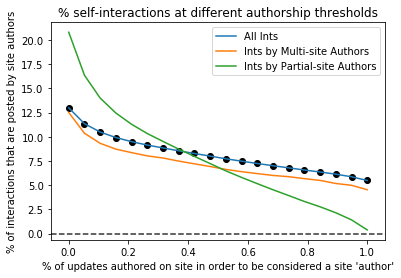

In [72]:
plt.plot(np.linspace(0, 1, 20), selfinteraction_proportion_list[:,0] * 100, label='All Ints')
plt.scatter(np.linspace(0, 1, 20), selfinteraction_proportion_list[:,0] * 100, color='black')
plt.plot(np.linspace(0, 1, 20), selfinteraction_proportion_list[:,1] * 100, label='Ints by Multi-site Authors')
plt.plot(np.linspace(0, 1, 20), selfinteraction_proportion_list[:,2] * 100, label='Ints by Partial-site Authors')
plt.axhline(0, color='black', alpha=0.8, linestyle="--")
plt.title("% self-interactions at different authorship thresholds")
plt.xlabel("% of updates authored on site in order to be considered a site 'author'")
plt.ylabel("% of interactions that are posted by site authors")
plt.legend()
plt.show()

In [68]:
# these are the proportions when the threshold is 100%
selfinteraction_proportion_list[-1]
# note that the partial-site authorship % is nonzero, which is
# caused by multi-site authors who have some partial-authored sites and some full-authored sites

array([0.05478165, 0.04523872, 0.00371064])

In [43]:
def compute_individual_author_selfinteraction_proportion(threshold):
    thresholded_author_user_id_to_site_id_map = {user_id: set([site_id 
                                                   for site_id, site_update_count, site_total_update_count 
                                                   in zip(site_id_list, site_update_count_list, site_total_update_count_list)
                                                   if site_update_count / site_total_update_count >= threshold]) 
                                     for user_id, site_id_list, site_update_count_list, site_total_update_count_list 
                                     in zip(author_df.user_id, author_df.site_id_list, author_df.site_update_count_list, author_df.site_total_update_count_list)}
    is_self_interaction = [site_id in thresholded_author_user_id_to_site_id_map[user_id]
                                 for user_id, site_id 
                                 in zip(ints_df.user_id, ints_df.site_id)]
    
    is_self_interaction_series = pd.Series(data=is_self_interaction, index=ints_df.index)

    user_props = []
    is_self_interaction_indices = set(is_self_interaction_series[is_self_interaction_series].index)
    for user_id, group in tqdm(ints_df.groupby('user_id', sort=False), desc=f"Thresh={threshold:.2f}"):
        is_self_interaction_count = 0
        for ix in group.index:
            if ix in is_self_interaction_indices:
                is_self_interaction_count += 1
        prop = is_self_interaction_count / len(group)
        user_props.append(prop)
    
    return user_props
    

In [62]:
thresholds = np.linspace(0, 1, 10)
author_selfinteraction_proportions_list = [
    compute_individual_author_selfinteraction_proportion(thresh) for thresh in thresholds
]

100%|██████████| 275291/275291 [01:05<00:00, 4220.25it/s]


In [63]:
author_proportions = []
for thresh, user_props in zip(thresholds, author_selfinteraction_proportions_list):
    zero_count = np.sum([p == 0.0 for p in user_props])  # number of authors with ZERO self-interactions
    one_count = np.sum([p == 1.0 for p in user_props])  # number of authors with ONLY self-interactions
    author_count = len(user_props)
    no_self_author_proportion = zero_count / author_count
    some_self_author_proportion = np.sum([p < 1.0 and p > 0.0 for p in user_props]) / author_count
    all_self_author_proportion = one_count / author_count
    author_proportions.append((no_self_author_proportion, some_self_author_proportion, all_self_author_proportion))
    print(f"{thresh:6.2f} {np.mean(user_props):.2f}% {np.median(user_props):.2f}% {zero_count/author_count:.2f}% {one_count/author_count:.2f}%")
author_proportions = np.array(author_proportions)
author_proportions.shape

  0.00 0.37% 0.13% 0.35% 0.24%
  0.11 0.34% 0.09% 0.39% 0.23%
  0.22 0.32% 0.06% 0.42% 0.21%
  0.33 0.31% 0.05% 0.44% 0.20%
  0.44 0.30% 0.03% 0.46% 0.20%
  0.56 0.28% 0.01% 0.48% 0.19%
  0.67 0.27% 0.00% 0.50% 0.18%
  0.78 0.26% 0.00% 0.52% 0.17%
  0.89 0.25% 0.00% 0.54% 0.17%
  1.00 0.23% 0.00% 0.57% 0.16%


(10, 3)

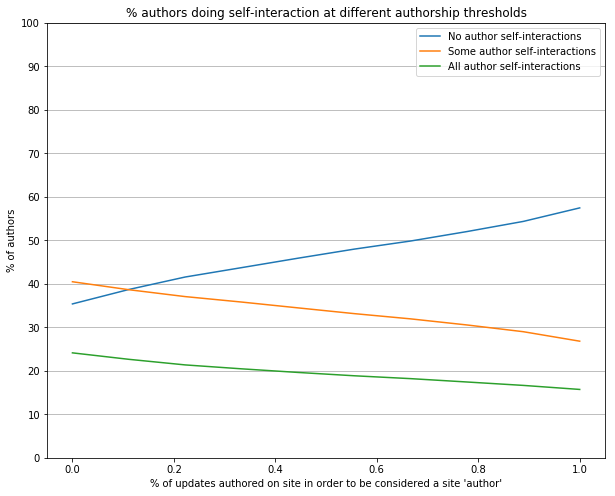

In [85]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plt.plot(thresholds, author_proportions[:,0] * 100, label='No author self-interactions')
plt.plot(thresholds, author_proportions[:,1] * 100, label='Some author self-interactions')
plt.plot(thresholds, author_proportions[:,2] * 100, label='All author self-interactions')
plt.ylim((0, 100))
plt.title("% authors doing self-interaction at different authorship thresholds")
plt.xlabel("% of updates authored on site in order to be considered a site 'author'")
plt.ylabel("% of authors")
plt.legend()
plt.grid(axis='y')
plt.yticks(ticks=range(0, 110, 10))
plt.show()

In [72]:
# what percent of authors actually differ according to the threshold? 22.8%
# a slightly lower % than the number who actually partial-author (26%)
# This is lower because not all authors who partial-author self-interact on the sites they partially interacted with
# But, this implies that a very large proportion (85-90% of patial-site authors) also self-interact on those sites
zero = author_selfinteraction_proportions_list[0]
one = author_selfinteraction_proportions_list[-1]
has_different_selfinteraction_proportion = [i for i, u0, u1 in zip(range(len(zero)), zero, one) if u0 != u1]
len(has_different_selfinteraction_proportion) / len(zero)

0.22767907414336103

In [1]:
0.22767907414336103 / 0.2669840218561139

0.8527816479821569

In [76]:
subset_author_proportions = []
different_selfinteraction_proportion_inds = set(has_different_selfinteraction_proportion)
for thresh, user_props in tqdm(zip(thresholds, author_selfinteraction_proportions_list), total=len(thresholds)):
    subset_user_props = [p for i, p in enumerate(user_props) if i in different_selfinteraction_proportion_inds]
    zero_count = np.sum([p == 0.0 for p in subset_user_props])  # number of authors with ZERO self-interactions
    one_count = np.sum([p == 1.0 for p in subset_user_props])  # number of authors with ONLY self-interactions
    author_count = len(subset_user_props)
    no_self_author_proportion = zero_count / author_count
    some_self_author_proportion = np.sum([p < 1.0 and p > 0.0 for p in subset_user_props]) / author_count
    all_self_author_proportion = one_count / author_count
    subset_author_proportions.append((no_self_author_proportion, some_self_author_proportion, all_self_author_proportion))
subset_author_proportions = np.array(subset_author_proportions)
subset_author_proportions.shape


100%|██████████| 10/10 [00:00<00:00, 19.23it/s]

(10, 3)

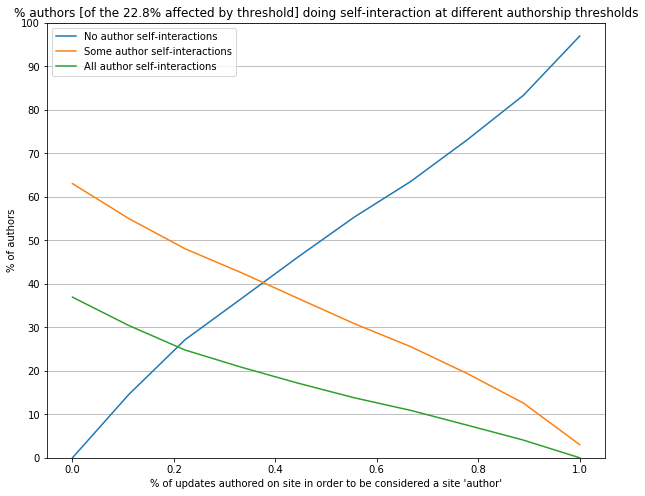

In [86]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
plt.plot(thresholds, subset_author_proportions[:,0] * 100, label='No author self-interactions')
plt.plot(thresholds, subset_author_proportions[:,1] * 100, label='Some author self-interactions')
plt.plot(thresholds, subset_author_proportions[:,2] * 100, label='All author self-interactions')
plt.ylim((0, 100))
plt.title(f"% authors [of the {len(has_different_selfinteraction_proportion) / len(zero)*100:.1f}% affected by threshold] doing self-interaction at different authorship thresholds")
plt.xlabel("% of updates authored on site in order to be considered a site 'author'")
plt.ylabel("% of authors")
plt.legend()
plt.grid(axis='y')
plt.yticks(ticks=range(0, 110, 10))
plt.show()

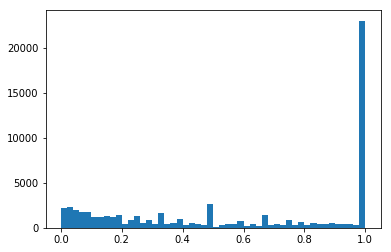

(0.00020242914979757084, 1.0)

In [89]:
# what is the distribution of the difference in self-authorship proportion for authors who are affected by the threshold?
zero = author_selfinteraction_proportions_list[0]
one = author_selfinteraction_proportions_list[-1]
difference_in_selfinteraction_proportion = [u0 - u1 for u0, u1 in zip(zero, one) if u0 != u1]
plt.hist(difference_in_selfinteraction_proportion, bins=50)
plt.show()
np.min(difference_in_selfinteraction_proportion), np.max(difference_in_selfinteraction_proportion)

In [92]:
# 36% of the probability mass in the above plot of differences is in the "1.0" column
len([d for d in difference_in_selfinteraction_proportion if d == 1]) / len(difference_in_selfinteraction_proportion)

0.3650084559175468

In [93]:
len([d for d in difference_in_selfinteraction_proportion if d == 0.5]) / len(difference_in_selfinteraction_proportion)

0.04098726825999553

This histogram shows that most authors who are affected by the authorship threshold have only a portion of their interactions reclassified by setting the threshold.

However, a sizeable portion (36%) have their entire interaction history reclassified based on the setting of the threshold.

I should qualitatively investigate some of the users that have this complete difference. What is the nature of their authorship on the sites in question?

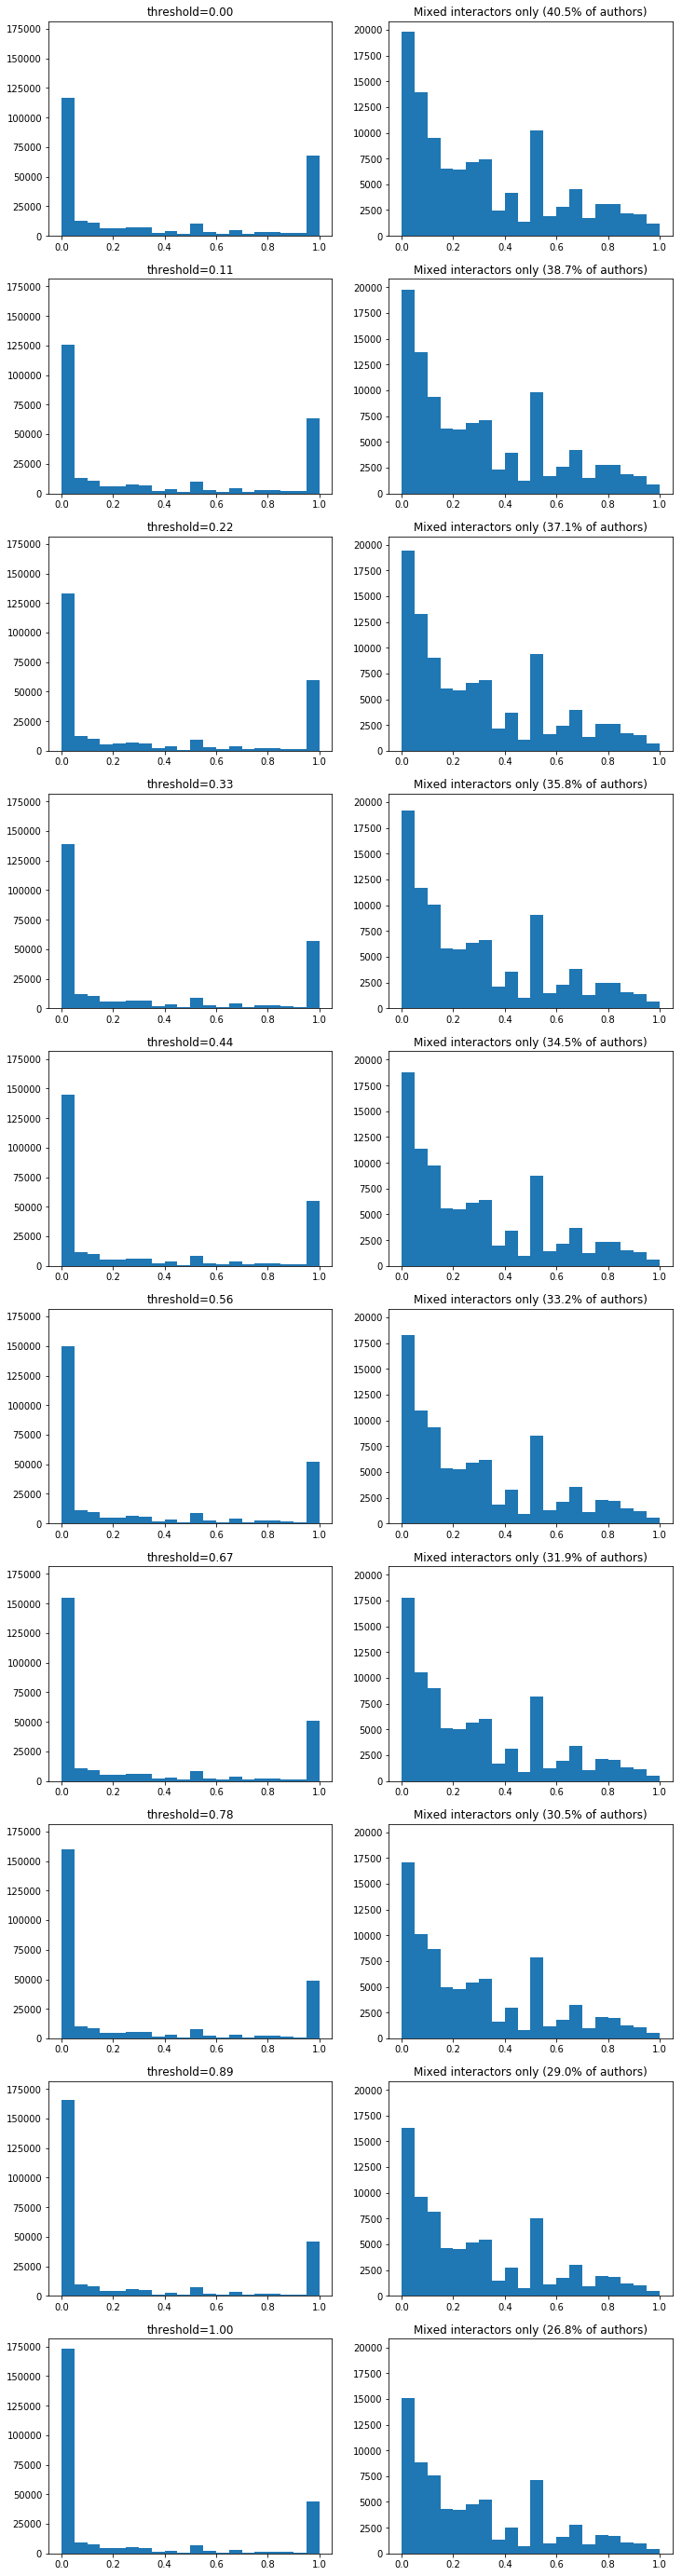

In [68]:
fig, axes = plt.subplots(len(thresholds), 2, figsize=(12,5*len(thresholds)), sharey='col', squeeze=False)
for thresh, ax_row, user_props in zip(thresholds, axes, author_selfinteraction_proportions_list):
    ax = ax_row[0]
    ax.hist(user_props, bins=20)
    ax.set_title(f"threshold={thresh:.2f}")
    ax = ax_row[1]
    x = [p for p in user_props if p > 0 and p < 1]
    ax.hist(x, bins=20)
    ax.set_title(f"Mixed interactors only ({len(x)/len(user_props)*100:.1f}% of authors)")
    
plt.show()

#### Site-level analysis

Goal here is to estimate how many TIES are actually affected, i.e. how many USER -> SITE links will be added or removed based on the threshold setting.

In [99]:
def compute_individual_author_site_counts(threshold):
    thresholded_author_user_id_to_site_id_map = {user_id: set([site_id 
                                                   for site_id, site_update_count, site_total_update_count 
                                                   in zip(site_id_list, site_update_count_list, site_total_update_count_list)
                                                   if site_update_count / site_total_update_count >= threshold]) 
                                     for user_id, site_id_list, site_update_count_list, site_total_update_count_list 
                                     in zip(author_df.user_id, author_df.site_id_list, author_df.site_update_count_list, author_df.site_total_update_count_list)}
    is_self_interaction = [site_id in thresholded_author_user_id_to_site_id_map[user_id]
                                 for user_id, site_id 
                                 in zip(ints_df.user_id, ints_df.site_id)]
    
    is_self_interaction_series = pd.Series(data=is_self_interaction, index=ints_df.index)

    user_site_counts = []
    is_self_interaction_indices = set(is_self_interaction_series[is_self_interaction_series].index)
    for user_id, group in tqdm_notebook(ints_df.groupby('user_id', sort=False), desc=f"Thresh={threshold:.2f}"):
        all_site_ids = set(group.site_id)
        selfinteraction_site_ids = set()
        is_self_interaction_count = 0
        for ix, site_id in zip(group.index, group.site_id):
            if ix in is_self_interaction_indices:
                selfinteraction_site_ids.add(site_id)
        user_site_counts.append((len(selfinteraction_site_ids), len(all_site_ids)))
    
    return user_site_counts
    

In [100]:
thresholds = np.linspace(0, 1, 5)
author_site_counts_list = [
    compute_individual_author_site_counts(thresh) for thresh in thresholds
]

In [103]:
mean_site_proportion_selfinteracted = []
total_outdegrees = []
for author_site_counts in author_site_counts_list:
    props = []
    outdegrees = []
    total_outdegree = 0
    for self_site_count, total_site_count in author_site_counts:
        prop = self_site_count / total_site_count
        props.append(prop)
        outdegree = total_site_count - self_site_count
        outdegrees.append(outdegree)
        total_outdegree += outdegree
    total_outdegrees.append(total_outdegree)
    mean_site_proportion_selfinteracted.append(np.mean(props))

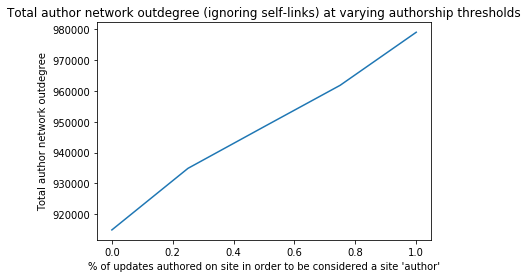

(64196, 914896, 979092)

In [110]:
plt.plot(thresholds, total_outdegrees)
plt.title(f"Total author network outdegree (ignoring self-links) at varying authorship thresholds")
plt.xlabel("% of updates authored on site in order to be considered a site 'author'")
plt.ylabel("Total author network outdegree")
plt.show()
total_outdegrees[-1] - total_outdegrees[0], total_outdegrees[0], total_outdegrees[-1]

In [111]:
# 6.6% (64196) of the interaction links in the User/Site network with a 100% site authorship requirement
# would be self-links if the authorship requirement were 1+ update on a site
(total_outdegrees[-1] - total_outdegrees[0]) / total_outdegrees[-1]

0.06556687216318793

In [112]:
# 3.5% (33517) of the interaction links in the User/Site network with a 50% site authorship requirement
# would be self-links if the authorship requirement were 1+ update on a site
(total_outdegrees[2] - total_outdegrees[0]) / total_outdegrees[2]

0.035340089180557414